In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
import os
os.chdir("/content/drive/MyDrive/Colab/GAN")

In [129]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Dense , Input , BatchNormalization , LeakyReLU , Conv2D
from keras.layers import Activation , Flatten , Reshape , Conv2DTranspose , Layer
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from keras.datasets import mnist
from keras.utils import plot_model

In [130]:
# hyper parameters

latent_dim = 100
image_size = 28
image_shape = (image_size, image_size, 1)

gen_filters = [128, 64, 32, 1]
gen_strides = [2, 2, 1, 1]

dis_filters = [32, 64, 128, 256]
dis_strides = [2, 2, 2, 1]


kernel_size = 5
strides = 2
alpha = 0.2

batch_size = 64

dis_lr = 2e-4
dis_decay = 6e-8
dis_optimizer = RMSprop(lr=dis_lr, weight_decay=dis_decay)

adv_lr = dis_lr * 0.5
adv_decay = dis_decay * 0.5
adv_optimizer = RMSprop(lr=adv_lr, weight_decay=adv_decay)

save_intervals = 500
train_steps = 40000
log_print_steps = 50
test_size = 16


In [131]:
(x_train , _) , (x_test , _) = mnist.load_data()
x_train = x_train.reshape(-1 , image_size , image_size , 1).astype('float32')/255

In [132]:
os.makedirs('images' , exist_ok=True)

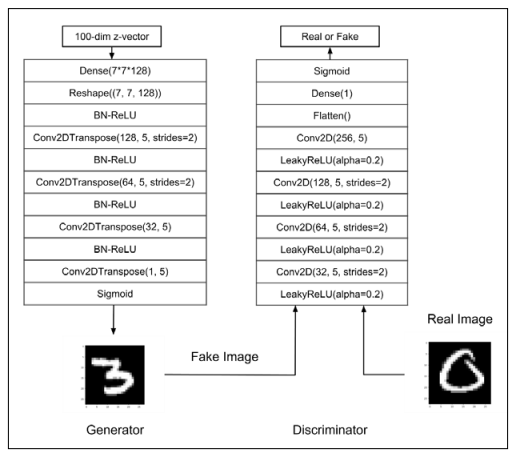

In [133]:
from IPython.display import Image
Image('dcgan.png')

In [134]:
def bn_relu(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [135]:
def build_generator(inputs, image_size=28):
    """Build a Generator Model
        Stack of BN-ReLU-Conv2DTranpose to generate fake images.
        Output activation is sigmoid instead of tanh in [1].
        Sigmoid converges easily.
    # Arguments
        inputs (Layer): Input layer of the generator (the z-vector)
        image_size: Target size of one side (assuming square image)
    # Returns
        Model: Generator Model
    """
    filters = gen_filters
    x = inputs

    image_resize = image_size // 4

    x = Dense(image_resize * image_resize * filters[0])(x)
    x = Reshape((image_resize, image_resize, filters[0]))(x)


    for strides, filter in zip(gen_strides, filters):
        x = bn_relu(x)
        x = Conv2DTranspose(filters = filter,
                            kernel_size=kernel_size,
                            padding='same',
                            strides= strides
                           )(x)
    outputs = Activation('sigmoid', name='Sigmoid')(x)
    model =Model(inputs, outputs, name='generator')
    model.summary()
    plot_model(model, to_file='generator.png', show_shapes=True)
    return model


In [136]:
def build_discriminator(inputs):

    """ Build a Discriminator Model
        Stack of LeakyReLU-Conv2D to discriminate real from fake.
        The network does not converge with BN so it is not used here
        unlike in [1] or original paper.
        # Arguments
            inputs (Layer): Input layer of the discriminator (the image)
        # Returns
            Model: Discriminator Model
    """
    x = inputs
    for strides, filter in zip(dis_strides, dis_filters):
        x = LeakyReLU(alpha=alpha)(x)
        x = Conv2D(filters = filter,
                            kernel_size=kernel_size,
                            padding='same',
                            strides= strides
                           )(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    outputs = Activation('sigmoid', name='Sigmoid')(x)
    model = Model(inputs, outputs, name='discriminator')
    return model


In [137]:
def build_and_train():

  dis_inputs = Input(shape=image_shape, name='dis_inputs')
  dis = build_discriminator(dis_inputs)
  dis.compile(loss='binary_crossentropy',
              optimizer=dis_optimizer,
              metrics=['acc']
              )

  gen_inputs = Input(shape=(latent_dim,), name='gen_inputs')
  gen = build_generator(gen_inputs)



  dis.trainable = False
  adv_inputs = gen_inputs
  adv_outputs = dis(gen(gen_inputs))
  adv = Model(adv_inputs, adv_outputs, name='adversarial')
  adv.compile(loss='binary_crossentropy',
              optimizer=adv_optimizer,
              metrics=['acc']
              )
  adv.summary()
  plot_model(adv, to_file='adversarial.png', show_shapes=True)

  models = gen , dis , adv

  train(models)

In [138]:
def train(models):
  """
      Train the Discriminator and Adversarial Networks
      Alternately train Discriminaor and Adversarial networks by batch.
      Discriminator is trained first with properly real and fake images.
      Adversarial is trained next with fake images pretending to be real
      Generate sample images per save_interval.

  # Arguments
      models (tuple): Generator, Discriminator, Adversarial models
  """

  gen, dis, adv = models
  m_train = x_train.shape[0]

  test_z = np.random.uniform(low=-1, high=+1, size=[test_size, latent_dim])

  for step in range(1, train_steps + 1):
      random_indices = np.random.randint(0, m_train, size=batch_size)
      real_images = x_train[random_indices]


      z = np.random.uniform(low=-1, high=+1, size=[batch_size, latent_dim])
      fake_images = gen.predict(z)


      fake_labels = np.zeros((batch_size, 1))
      real_labels = np.ones((batch_size, 1))

      dis_x = np.concatenate([real_images, fake_images])
      dis_y = np.concatenate([real_labels, fake_labels])

      loss, acc = dis.train_on_batch(dis_x, dis_y)
      log = f'step:{step} dis[loss:{loss}, acc:{acc}]'

      adv_x = np.random.uniform(low=-1, high=+1, size=[batch_size, latent_dim])
      adv_y = np.ones((batch_size, 1))

      loss, acc= adv.train_on_batch(adv_x, adv_y)
      log += f'adv[loss:{loss}, acc:{acc}]'

      print(log)
      if step % save_intervals == 0:
          plot_images(gen, test_z, step)

In [139]:
def plot_images(generator, noise_input, step, show=True):
  """Generate fake images and plot them

  For visualization purposes, generate fake images
  then plot them in a square grid

  # Arguments
      generator (Model): The Generator Model for fake images generation
      noise_input (ndarray): Array of z-vectors
      show (bool): Whether to show plot or not
      step (int): Appended to filename of the save images
  """
  image_address = 'images'

  z = noise_input
  n_images = z.shape[0]

  rows = int(np.sqrt(n_images))
  plt.figure(figsize=(2, 2))
  images = generator.predict(z)
  image_size = images.shape[1]

  for i in range(n_images):
      plt.subplot(rows,rows, i+1)
      plt.imshow(images[i].reshape((image_size, image_size)), cmap='gray')
      plt.axis('off')
  plt.savefig(os.path.join(image_address , f"{step}.png"))

  if show:
      plt.show()
  else:
      plt.close('all')

In [140]:
build_and_train()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def test_generator(generator):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    plot_images(generator,
                noise_input=noise_input,
                show=True,
                model_name="test_outputs")